# Tutorial 6: 2D Anisotropic Diffusion


In this tutorial, we consider the following anisotropic diffusion problem

$$
	a(v, u) = \int_{\Omega}  \frac{\kappa_{\parallel}}{\|\mathbf{B}\|^2} (\textbf{B} \cdot \nabla v) (\textbf{B} \cdot \nabla u) + \kappa_{I} \nabla v \cdot \nabla u d\Omega, \quad \forall u,v \in \mathcal{V}_h
$$

where $\textbf{B}$ denotes the magnetic field, $\Omega$ is our 2D computational domain and $\mathcal{V}_h \subset H^1(\Omega)$. 
We are interested in highly anisotropic configurations with $\displaystyle \frac{\kappa_{\parallel}}{\kappa_{I}} \simeq 10^6 \gg 1$.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from vale import construct_model
import numpy as np
import os
import clapp.common.utils      as clapp_utils

# ... initializing Clapp
clapp_utils.initialize()
# ...

# ...
def construct_pde(filename, mapping, discretization):
    # ... clean input directory. needed for Fortran
    cmd = "rm -rf input"
    os.system(cmd)
    # ...

    # ... creates discretization parameters
    from clapp.disco.parameters.bspline import BSpline

    bspline_params = BSpline(discretization["n_elements"], \
                             discretization["degrees"], \
                             bc_min=[1,1], \
                             bc_max=[1,1])
    # ...

    # ... create a context from discretization
    from clapp.fema.context        import Context

    context = Context(dirname="input", \
                      discretization_params=bspline_params)
    # ...

    # ...
    pde = construct_model(filename, backend="clapp", \
                          context=context, mapping=mapping)
    # ...
    
    # ... clean input directory
    cmd = "rm -rf input"
    os.system(cmd)
    # ...
    
    return pde
# ...

We use **CAID** to create the geometry, then convert it to the *mapping* object from *CLAPP*

In [2]:
# ... creates a unit line geometry using CAID
from caid.cad_geometry import square
geometry = square()
# ...
    
# ...
from clapp.spl.mapping import Mapping
mapping = Mapping(geometry=geometry)
# ...

The following flag allows to assemble the involved matrices

In [3]:
with_matrix = False

In [8]:
constants = {"alpha": 1.e4, "beta": 1.}

In [20]:
# ... define a discretization
discretization = {"n_elements": [64,64], "degrees": [4,4]}
# ...

pde = construct_pde(filename="../../glt/tests/2d/inputs/anisotropic_diffusion.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form = pde["a"]
b1   = pde["b1"]
b2   = pde["b2"]

# ... set user functions
b1.set("1.1659397624413860850012270020670/1.5360389088958246")
b2.set("1.0/1.5360389088958246")
# ...

# ... set user constants
form.assembler.set_constants(constants)
# ...

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_a = glt_symbol_from_weak_formulation(pde["a"], 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization, 
                                          user_constants=constants)
# ...

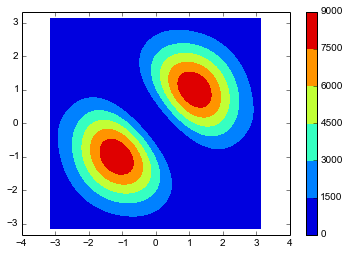

In [21]:
# ... lambdify the glt symbol
from glt.expression import glt_lambdify

f_a = glt_lambdify(expr_a, dim=2)
# ...

# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = np.linspace(-np.pi,np.pi, nx)
t2 = np.linspace(-np.pi,np.pi, ny)

u = np.linspace(0.,1.,nx)
v = np.linspace(0.,1.,ny)

x = mapping.evaluate(u,v)[0,:,:]
y = mapping.evaluate(u,v)[1,:,:]

t1, t2 = np.meshgrid(t1, t2)

f = f_a(x,y,t1,t2);
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

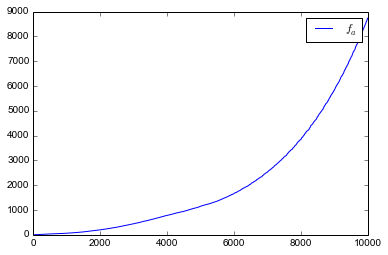

In [22]:
F = f.ravel()
F.sort()
plt.plot(F, "-b", label="$f_a$")
plt.legend();

Let's now create the symbol for linear B-Splines

In [23]:
# ... define a discretization
discretization_p = {"n_elements": discretization["n_elements"], "degrees": [1,1]}
# ...

pde_p = construct_pde(filename="../../glt/tests/2d/inputs/anisotropic_diffusion.vl", 
                    mapping=mapping, 
                    discretization=discretization_p)

form = pde_p["a"]

# ... set user constants
form.assembler.set_constants(constants)
# ...

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_p = glt_symbol_from_weak_formulation(pde_p["a"], 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization_p, 
                                          user_constants=constants)
# ...

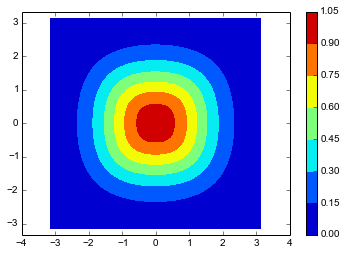

In [24]:
# ... lambdify the glt symbol
from glt.expression import glt_lambdify

f_a = glt_lambdify(expr_a, dim=2)
f_p = glt_lambdify(expr_p, dim=2)
# ...

# ... compute the symbol f_a / f_p
nx = 100 ; ny = 100
t1 = np.linspace(-np.pi,np.pi, nx)
t2 = np.linspace(-np.pi,np.pi, ny)

u = np.linspace(0.,1.,nx)
v = np.linspace(0.,1.,ny)

x = mapping.evaluate(u,v)[0,:,:]
y = mapping.evaluate(u,v)[1,:,:]

t1, t2 = np.meshgrid(t1, t2)

f = f_a(x,y,t1,t2)/f_p(x,y,t1,t2);
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

Now, let's fix the high order pathology

In [25]:
discretization_c = {"n_elements": discretization["n_elements"], 
                    "degrees": [discretization["degrees"][0]-1,discretization["degrees"][1]-1]}

pde_c = construct_pde(filename="../../glt/tests/2d/inputs/mass.vl", 
                    mapping=mapping, 
                    discretization=discretization)

form_c = pde_c["c"]

# ... compute the glt symbol and evaluate it
from glt.expression import glt_symbol_from_weak_formulation

expr_c = glt_symbol_from_weak_formulation(form_c, 
                                          verbose=False, evaluate=True, 
                                          discretization=discretization)

from glt.expression import glt_update_user_functions
expr_c = glt_update_user_functions(expr_c, form_c.functions)
# ...

In [37]:
# ... Finalizing Clapp
clapp_utils.finalize()
# ...